In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import tensorflow
import matplotlib.pyplot as plt

2025-12-09 19:03:18.614879: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-09 19:03:19.181656: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-09 19:03:20.687340: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


In [2]:
import torch

if torch.cuda.is_available():
    print("CUDA is available! GPU will be used.")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU device name: {torch.cuda.get_device_name(0)}") # Assuming device 0
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available! GPU will be used.
Number of GPUs: 1
Current GPU device name: NVIDIA GeForce RTX 4060 Ti


In [4]:
image_size = (180, 180)
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


I0000 00:00:1765275067.493677    9860 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5527 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


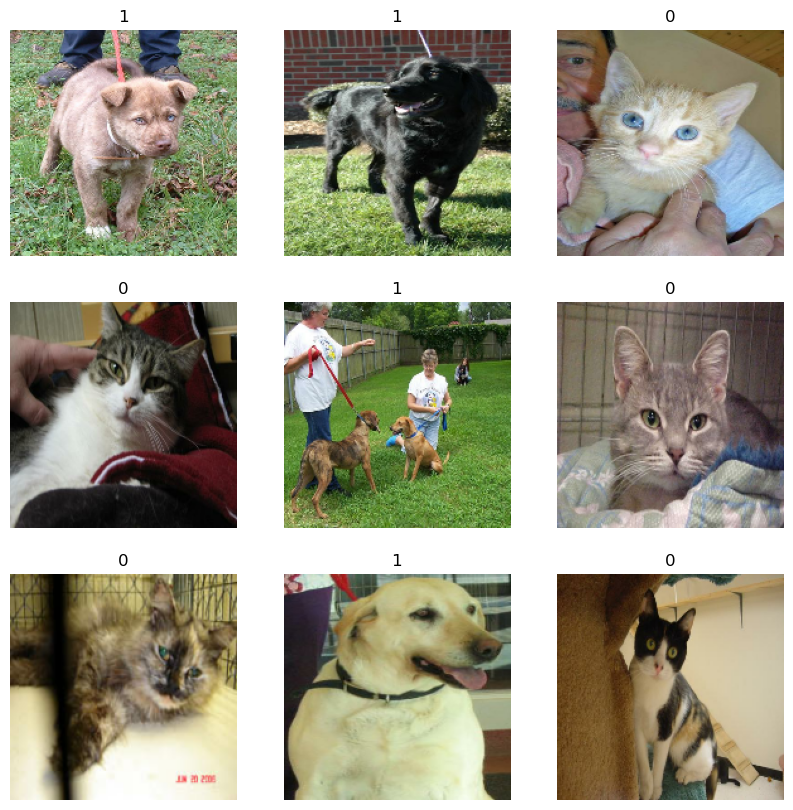

In [29]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

2025-12-09 19:12:26.659014: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


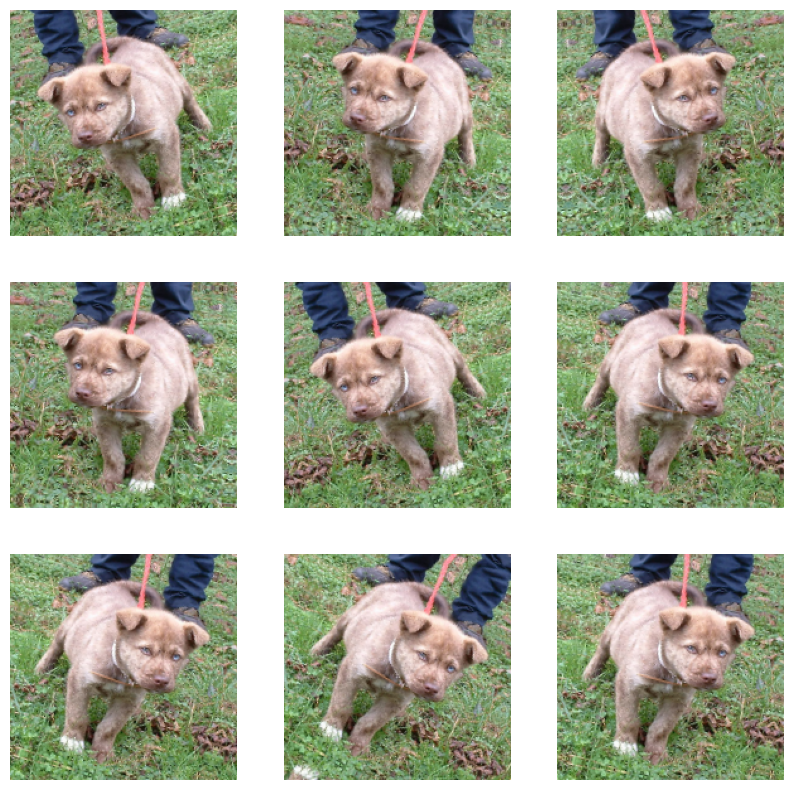

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [7]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)


# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

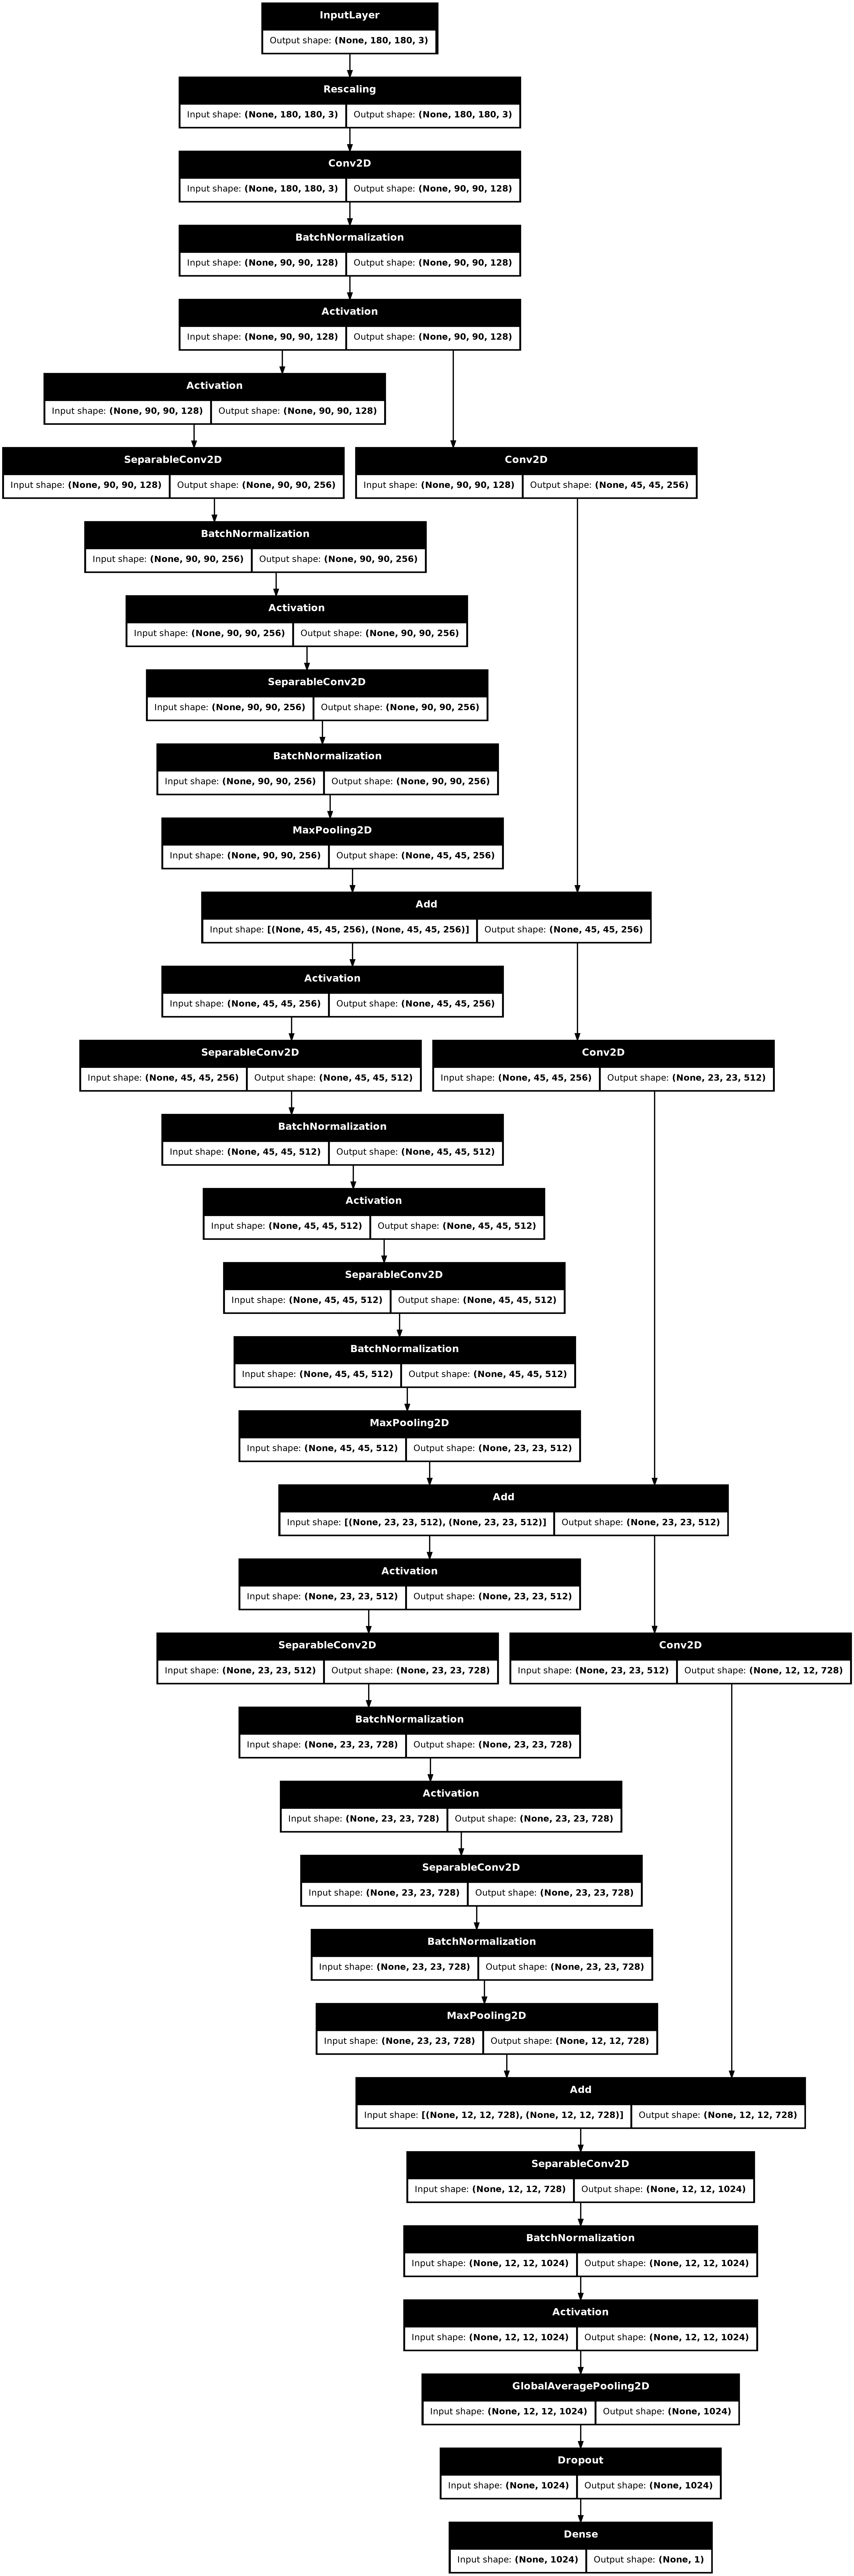

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [9]:
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


2025-12-09 19:14:55.402120: I external/local_xla/xla/service/service.cc:163] XLA service 0x1d1a3f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-09 19:14:55.402169: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-12-09 19:14:55.680688: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-09 19:14:56.343884: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-12-09 19:14:58.059884: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 19:14:58.175229: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: m

 15/586 ━━━━━━━━━━━━━━━━━━━━ 1:20 140ms/step - acc: 0.6199 - loss: 0.7403

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


312/586 ━━━━━━━━━━━━━━━━━━━━ 35s 130ms/step - acc: 0.6210 - loss: 0.6666

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


341/586 ━━━━━━━━━━━━━━━━━━━━ 31s 130ms/step - acc: 0.6236 - loss: 0.6627

422/586 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - acc: 0.6306 - loss: 0.6525

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


432/586 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - acc: 0.6314 - loss: 0.6513

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


454/586 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - acc: 0.6332 - loss: 0.6487

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


469/586 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - acc: 0.6344 - loss: 0.6470

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - acc: 0.6432 - loss: 0.6346

2025-12-09 19:16:37.922393: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 19:16:38.030250: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 19:16:39.255225: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 19:16:39.381839: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 19:16:40.524934: E external/local_xla/xla/stream_

586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - acc: 0.6433 - loss: 0.6345

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
2025-12-09 19:16:58.949983: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 19:16:59.056818: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 19:17:00.492101: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a miss

586/586 ━━━━━━━━━━━━━━━━━━━━ 133s 179ms/step - acc: 0.6845 - loss: 0.5760 - val_acc: 0.4957 - val_loss: 1.2954


2025-12-09 19:17:07.783933: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 19:17:07.900578: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 19:17:08.026457: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 19:17:08.147196: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-09 19:17:08.267219: E external/local_xla/xla/stream_

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
This image is 91.97% cat and 8.03% dog.


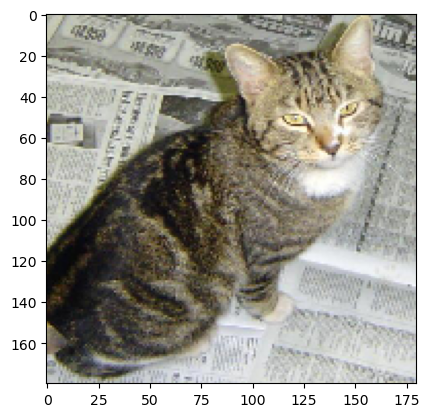

In [10]:
img = keras.utils.load_img("PetImages/Cat/7169.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

In [12]:
model.save("my_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
This image is 94.26% cat and 5.74% dog.


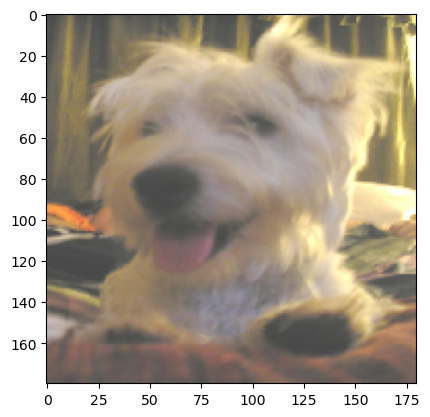

In [13]:
loaded_model = keras.models.load_model("my_model.keras")
img = keras.utils.load_img("PetImages/Dog/6759.jpg", target_size=image_size)

plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = loaded_model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")


In [14]:
type(img)

PIL.Image.Image

In [15]:
type(img_array)

tensorflow.python.framework.ops.EagerTensor

In [16]:
img_array

<tf.Tensor: shape=(1, 180, 180, 3), dtype=float32, numpy=
array([[[[ 75.,  75.,  73.],
         [ 78.,  78.,  76.],
         [ 77.,  77.,  75.],
         ...,
         [216., 205., 113.],
         [253., 235., 151.],
         [253., 237., 150.]],

        [[ 77.,  77.,  75.],
         [ 81.,  81.,  79.],
         [ 78.,  78.,  76.],
         ...,
         [205., 194., 104.],
         [252., 234., 150.],
         [253., 237., 152.]],

        [[ 81.,  81.,  79.],
         [ 80.,  80.,  78.],
         [ 79.,  79.,  77.],
         ...,
         [180., 174.,  88.],
         [249., 234., 151.],
         [253., 243., 158.]],

        ...,

        [[108.,  93.,  88.],
         [108.,  93.,  88.],
         [106.,  93.,  87.],
         ...,
         [121., 103.,  93.],
         [120., 101.,  94.],
         [118.,  99.,  92.]],

        [[108.,  94.,  93.],
         [105.,  94.,  92.],
         [ 99.,  89.,  87.],
         ...,
         [117.,  99.,  89.],
         [114.,  95.,  88.],
         